In [61]:
import json
import numpy as np
import os
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns


def parse_values(line):
    """Parse the line containing private values"""
    # Format: "Your private values are 16 for item 1, 46 for item 2, 100 for item 3, 23 for item 4, 47 for item 5."
    values = []
    parts = line.split("are ")[1].split(", ")
    for part in parts:
        value = int(part.split(" for item")[0])
        values.append(value)
    return values

def parse_outside_offer(line):
    """Parse the line containing outside offer"""
    # Format: "Your outside offer value is 145. Your objective..."
    return int(line.split("value is ")[1].split(".")[0])

def calculate_value(items_received, values):
    """Calculate value of items received given the player's values"""
    return sum(items_received[i] * values[i] for i in range(len(values)))

def analyze_single_game(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    results = []
    for game in data['all_game_data']:
        agent1 = game['agent1']
        agent2 = game['agent2']
        
        # Remove Agent1_ and Agent2_ prefixes if they exist
        if agent1.startswith("Agent1_"):
            agent1 = agent1[7:]
        if agent2.startswith("Agent2_"):
            agent2 = agent2[7:]
        
        # Track the final state
        final_action = None
        final_round_index = len(game['round_data']) - 1
        final_offer = None
        p1_outside_offer = None
        p2_outside_offer = None
        p1_values = None
        p2_values = None
        num_items = None
        
        # First, gather all the necessary data from all rounds
        for round_idx, round_data in enumerate(game['round_data']):
            prompt = round_data['prompt']
            
            # Check if this is the final round
            if round_idx == final_round_index:
                final_action = round_data['action']
            
            if "You are Player 1" in prompt:
                # Extract Player 1's values and outside offer
                for line in prompt.split('\n'):
                    if "Your private values are" in line:
                        p1_values = parse_values(line)
                    elif "Your outside offer value is" in line:
                        p1_outside_offer = parse_outside_offer(line)
                    elif "There are" in line and "units of item" in line:
                        if num_items is None:
                            # Extract numbers before "units of item"
                            nums = []
                            parts = line.split("There are ")[1].split(", ")
                            for part in parts:
                                num = int(part.split(" units")[0])
                                nums.append(num)
                            num_items = nums
            elif "You are Player 2" in prompt:
                # Extract Player 2's values and outside offer
                for line in prompt.split('\n'):
                    if "Your private values are" in line:
                        p2_values = parse_values(line)
                    elif "Your outside offer value is" in line:
                        p2_outside_offer = parse_outside_offer(line)
            
            # Track the current offer
            if "Current offer on the table" in prompt:
                offer_line = prompt.split("Current offer on the table")[1].split("\n")[0]
                if "None" not in offer_line and "[" in offer_line:
                    final_offer = eval(offer_line[offer_line.find("["):offer_line.find("]")+1])
        
        # Calculate final values
        p1_final_value = None
        p2_final_value = None
        
        if final_action == "WALK":
            p1_final_value = p1_outside_offer
            p2_final_value = p2_outside_offer
        elif final_action == "ACCEPT":
            # Determine which player accepted the offer
            accepting_player = None
            for round_idx, round_data in enumerate(game['round_data']):
                if round_idx == final_round_index and round_data['action'] == "ACCEPT":
                    accepting_player = 1 if "You are Player 1" in round_data['prompt'] else 2
            
            if accepting_player == 2:
                # Player 2 accepted the offer
                # The offer represents what Player 2 receives
                p2_items = final_offer
                p1_items = [num_items[i] - final_offer[i] for i in range(len(final_offer))]
            else:
                # Player 1 accepted the offer
                # The offer represents what Player 1 receives
                p1_items = final_offer
                p2_items = [num_items[i] - final_offer[i] for i in range(len(final_offer))]
            
            p1_final_value = calculate_value(p1_items, p1_values)
            p2_final_value = calculate_value(p2_items, p2_values)
        
        # Extract circle values from the data
        try:
            # Check if circle is an integer or a list
            circle_data = data['all_game_data'][0]['circle']
            if isinstance(circle_data, int):
                # If it's just an integer, both players have the same circle
                p1_circle = circle_data
                p2_circle = circle_data
            else:
                # If it's a list, extract individual values
                p1_circle = circle_data[0]
                p2_circle = circle_data[1]
        except (KeyError, TypeError, IndexError):
            # Handle missing or malformed data
            p1_circle = None
            p2_circle = None
        
        # Add circle values to agent names if available
        agent1_with_circle = f"{agent1}_circle_{p1_circle}" if p1_circle is not None else agent1
        agent2_with_circle = f"{agent2}_circle_{p2_circle}" if p2_circle is not None else agent2
        
        results.append({
            'agent1': agent1_with_circle,
            'agent2': agent2_with_circle,
            'final_action': final_action,
            'agent1_value': p1_final_value,
            'agent2_value': p2_final_value,
        })
    
    return results

# Example usage:
file_path = "crossplay/sonnet_3.7_gemini_circle_6_vs_circle_2/all_game_data_3_1_2025_20_anthropic_3.7_sonnet_vs_gemini_2.0_flash_circle_p1_6_circle_p2_2.json"
results = analyze_single_game(file_path)

# Calculate average utility for each agent
agent1_values = [game['agent1_value'] for game in results if game['agent1_value'] is not None]
agent2_values = [game['agent2_value'] for game in results if game['agent2_value'] is not None]

agent1_avg = np.mean(agent1_values) if agent1_values else "N/A"
agent2_avg = np.mean(agent2_values) if agent2_values else "N/A"

# Print results for this file
# for i, game in enumerate(results):
#     print(f"\nGame {i+1} between {game['agent1']} and {game['agent2']}")
#     print(f"Final action: {game['final_action']}")
#     print(f"Final values: Agent1: {game['agent1_value']}, Agent2: {game['agent2_value']}")

print("\nAverage Utilities:")
print(f"Agent1 ({results[0]['agent1']}): {agent1_avg}")
print(f"Agent2 ({results[0]['agent2']}): {agent2_avg}")


Average Utilities:
Agent1 (anthropic_3.7_sonnet_circle_6): 527.05
Agent2 (gemini_2.0_flash_circle_2): 716.35


In [66]:
# Process all files in the crossplay directory
all_results = []
crossplay_dir = "crossplay"
agent_performance = defaultdict(lambda: defaultdict(list))

# Walk through all subdirectories in the crossplay directory
for root, dirs, files in os.walk(crossplay_dir):
    for file in files:
        if file.endswith('.json'):# and 'all_game_data' in file:
            file_path = os.path.join(root, file)
            try:
                game_results = analyze_single_game(file_path)
                
                # Skip files where one of the agents is openai_4o_circle_2
                if any('openai_4o_circle_2' in result['agent1'] or 'openai_4o_circle_2' in result['agent2'] 
                       for result in game_results):
                    print(f"Skipping {file_path} - contains openai_4o_circle_2")
                    continue
                
                all_results.extend(game_results)
                
                # Track performance by agent, including circle information
                for result in game_results:
                    agent1 = result['agent1']
                    agent2 = result['agent2']
                    
                    if result['agent1_value'] is not None:
                        agent_performance[agent1][agent2].append(result['agent1_value'])
                    
                    if result['agent2_value'] is not None:
                        agent_performance[agent2][agent1].append(result['agent2_value'])
                
                # Calculate and print per-file statistics
                agent1_values = [r['agent1_value'] for r in game_results if r['agent1_value'] is not None]
                agent2_values = [r['agent2_value'] for r in game_results if r['agent2_value'] is not None]
                
                agent1_avg = np.mean(agent1_values) if agent1_values else "N/A"
                agent2_avg = np.mean(agent2_values) if agent2_values else "N/A"
                # print(f"\nFile: {file_path}")
                # print(f"agent_1_name: {game_results[0]['agent1']}")
                # print(f"agent_2_name: {game_results[0]['agent2']}")
                # print(f"agent_1_average utility: {agent1_avg}")
                # print(f"agent_2_average utility: {agent2_avg}")
                
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

# Create a DataFrame from all results
df = pd.DataFrame(all_results)

# Calculate average performance for each agent against each opponent
agent_vs_opponent_performance = {}

for agent, opponents in agent_performance.items():
    for opponent, values in opponents.items():
        if values:
            key = f"{agent}_vs_{opponent}"
            agent_vs_opponent_performance[key] = np.mean(values)

# Calculate overall performance for each agent
overall_agent_performance = {}
for agent, opponents in agent_performance.items():
    all_values = []
    for values in opponents.values():
        all_values.extend(values)
    if all_values:
        overall_agent_performance[agent] = np.mean(all_values)

print(f"\nTotal games analyzed: {len(all_results)}")
print(f"Unique agent types: {len(overall_agent_performance)}")
print(f"Unique matchups: {len(agent_vs_opponent_performance)}")

# Create a matrix of agent performances against each other
all_agents = sorted(list(overall_agent_performance.keys()))
performance_matrix = pd.DataFrame(index=all_agents, columns=all_agents)

# Fill the matrix with average performance values
for agent, opponents in agent_performance.items():
    for opponent, values in opponents.items():
        if values:
            performance_matrix.loc[agent, opponent] = np.mean(values)



Skipping crossplay/gemini_4o_circle_5_vs_circle_2/all_game_data_2_23_2025_20_gemini_2.0_vs_4o_circle_p1_5_circle_p2_2.json - contains openai_4o_circle_2

Total games analyzed: 1841
Unique agent types: 8
Unique matchups: 64


In [63]:
performance_matrix

,anthropic_3.7_sonnet_circle_5,anthropic_3.7_sonnet_circle_6,gemini_2.0_flash_circle_2,gemini_2.0_flash_circle_5,openai_4o_circle_4,openai_4o_circle_5,openai_4o_circle_6,openai_o3_mini_circle_0
anthropic_3.7_sonnet_circle_5,579.648241,518.615385,642.948718,544.65,610.975,691.3,574.6,582.820513
anthropic_3.7_sonnet_circle_6,521.692308,611.120603,549.777778,477.575,712.868421,673.794872,617.184211,649.076923
gemini_2.0_flash_circle_2,647.179487,599.675676,557.386935,580.725,506.242424,580.0,645.028571,529.425
gemini_2.0_flash_circle_5,589.275,556.95,592.575,567.20202,533.615385,558.459459,676.709677,633.65
openai_4o_circle_4,592.575,575.25641,641.333333,618.589744,582.653061,654.736842,679.4,573.5
openai_4o_circle_5,654.8,621.05,600.259259,560.621622,559.410256,609.77551,608.075,607.625
openai_4o_circle_6,655.846154,528.342105,576.142857,517.419355,596.473684,655.275,606.25641,593.6
openai_o3_mini_circle_0,661.875,592.410256,559.051282,511.475,549.641026,728.825,655.128205,671.425


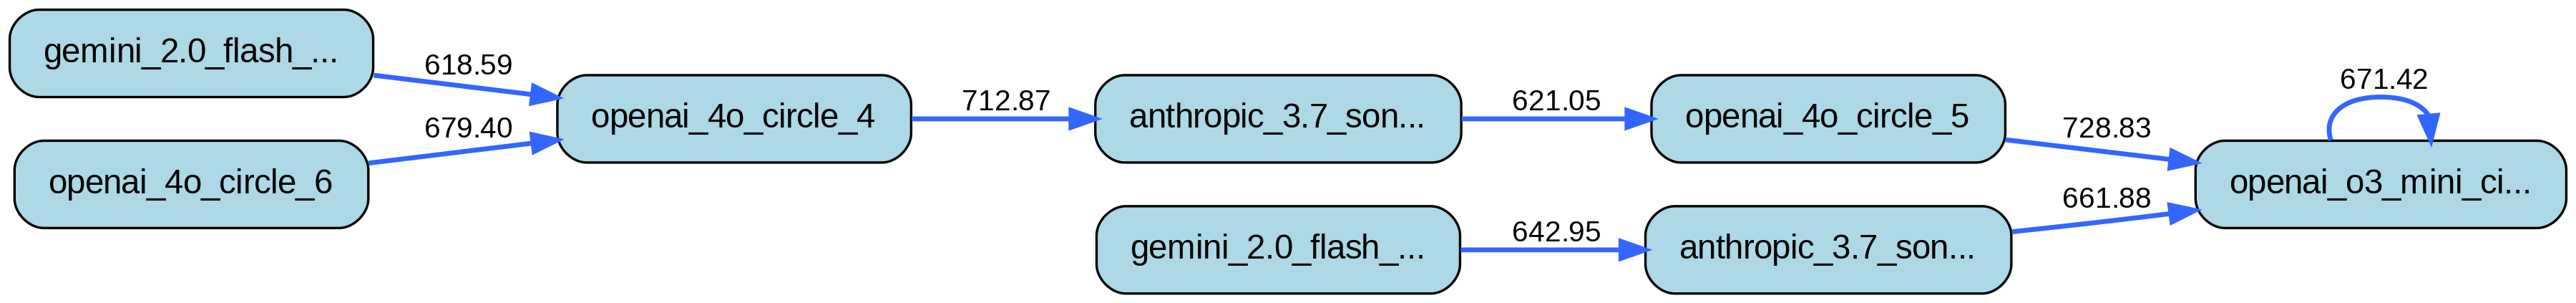

Error: no "view" mailcap rules found for type "image/png"
No applications found for mimetype: image/png
./usr/bin/xdg-open: 882: x-www-browser: Permission denied
/usr/bin/xdg-open: 882: firefox: Permission denied
/usr/bin/xdg-open: 882: iceweasel: Permission denied
/usr/bin/xdg-open: 882: seamonkey: Permission denied
/usr/bin/xdg-open: 882: mozilla: Permission denied
/usr/bin/xdg-open: 882: epiphany: Permission denied
/usr/bin/xdg-open: 882: konqueror: Permission denied
/usr/bin/xdg-open: 882: chromium: Permission denied
/usr/bin/xdg-open: 882: chromium-browser: Permission denied
/usr/bin/xdg-open: 882: google-chrome: Permission denied
/usr/bin/xdg-open: 882: links2: Permission denied
sh: 1: xli: Permission denied
/usr/bin/xdg-open: 882: elinks: Permission denied
/usr/bin/xdg-open: 882: links: Permission denied


>[24;1H8;24r                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

/usr/bin/xdg-open: 882: w3m: Permission denied
xdg-open: no method available for opening 'strategy_graph_graphviz.png'
sh: 1: xli: Permission denied


In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

# Assuming performance_matrix is your existing pandas DataFrame
# Create a new Graphviz graph
dot = Digraph(comment='Strategy Response Graph', format='png')
dot.attr(rankdir='LR', size='12,8', dpi='300', bgcolor='white')
dot.attr('node', shape='box', style='filled,rounded', fillcolor='lightblue', 
         fontname='Arial', fontsize='14', margin='0.2,0.1')
dot.attr('edge', fontname='Arial', fontsize='12', penwidth='2')

# Get strategy names from your DataFrame
strategy_names = performance_matrix.columns.tolist()

# Add nodes with cleaner labels (shorten if needed)
for strategy in strategy_names:
    # Create a shorter label if the strategy name is too long
    short_name = strategy
    if len(strategy) > 20:
        short_name = strategy[:17] + "..."
    
    dot.node(strategy, short_name)

# For each strategy (column), find the best response (highest value in column)
for strategy in strategy_names:
    # Get the column values
    column_values = performance_matrix[strategy]
    
    # Find the index of the best response (highest value)
    best_response = column_values.idxmax()
    best_value = column_values.max()
    
    # Add an edge from the strategy to its best response
    dot.edge(strategy, best_response, label=f" {best_value:.2f}", color='#3366FF')

# Render the graph
dot.render('strategy_graph_graphviz', view=True, cleanup=True)

# If you want to display it in the notebook
from IPython.display import Image, display
display(Image('strategy_graph_graphviz.png'))

In [6]:
(608.55 + 734.3)/2

671.425